# Connect to google account

In [1]:
# from google.colab import drive
# drive.mount('/content/data')

In [2]:
# # 코렙 한글깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Global Variables

In [3]:
import easydict
args = easydict.EasyDict()

# path 정보 
args.default_path = 'C:/dev/ML_basic/titanic/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 21
random.seed(21)
SEED=21
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [4]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [5]:
#train과 test는 이미 나눠져있음

ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [6]:
pd.read_csv(args.default_submission_csv).shape

(393, 2)

In [7]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [9]:
#고유번호가 유니크한지 확인
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [10]:
#passengerid를 제거, inplace는 True로 두면 drop한 결과 dataframe이 원본을 대체한다.
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [11]:
#test에서는 passengerid를 삭제하는 것이 아닌 index로 지정하였다.  ori_test에서 survieved라는 feature는 없다.
ori_test.set_index(['passengerid'], inplace=True) 
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [12]:
ori_train[['survived']].value_counts()

survived
0           570
1           346
Name: count, dtype: int64

In [13]:
#survived 의 value값을 0은 Died로 , 1은 Survived로 교체했다. 근데 이거 왜한거지
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [16]:
#index를 reset해주지 않았는데 왜일까

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=ori_train['survived'], random_state=args.random_state)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((732, 10), (184, 10), (732,), (184,))

# Base ModelV0

In [17]:
#Model V0, X_tr은 그대로 두기위하여 복사하여 가져왔다. ori_te는 절대 사용해서는 안된다.
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()
eda_train=pd.concat([train, y_tr],axis =1 )

train.shape, test.shape, ori_te.shape

((732, 10), (184, 10), (393, 10))

## Data Preprocessing

In [18]:
#cabin은 결측치가 아주많다. 그다음으로는 age이다.
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 38 to 277
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    732 non-null    int64  
 1   name      732 non-null    object 
 2   gender    732 non-null    object 
 3   age       589 non-null    float64
 4   sibsp     732 non-null    int64  
 5   parch     732 non-null    int64  
 6   ticket    732 non-null    object 
 7   fare      732 non-null    float64
 8   cabin     158 non-null    object 
 9   embarked  732 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 62.9+ KB


In [19]:
# # designation feature를 추가할시 해야할것:
# # 위에 feature drop에서 name 지우기, enc cols에 desigantion 추가하기



# train["name"] = train["name"].map(lambda x: x.strip())
# test["name"] = test["name"].map(lambda x: x.strip())
# ori_te["name"] = ori_te["name"].map(lambda x: x.strip())

# dict_designation = {
#     'Mr.': '남성',
#     'Master.': '남성',    #남
#     'Sir.': '남성',       #남
#     'Miss.': '미혼 여성',
#     'Mrs.': '기혼 여성',    
#     'Ms.': '미혼/기혼 여성',#여 Miss
#     'Lady.': '숙녀',  #여   Miss
#     'Mlle.': '아가씨',#여   Miss
#     # 직업
#     'Dr.': '의사',    #남 시대상.
#     'Rev.': '목사',   #남
#     'Major.': '계급', #남
#     'Don.': '교수',   #남
#     'Col.': '군인',   #남
#     'Capt.': '군인',  #남 
#     # 귀족
#     'Mme.': '영부인', #여   Mrs.
#     'Countess.': '백작부인',    #여 Mrs.
#     'Jonkheer.': '귀족'         #남
# }

# Mr = ['Mr.','Master.', 'Sir.', 'Dr.', 'Rev.' ,'Major.',  'Don.' , 'Col.' , 'Capt.']
# Miss = ['Miss.', 'Ms.', 'Lady.', 'Mlle.']
# Mrs = ['Mrs.', 'Mme.','Countess.', 'Jonkheer.' ]
# #위의 호칭중 없는것이 있다면 Miss으로 대체

# #호칭함수
# def add_designation(name): 
#   designation = "Miss."
#   for i in Mr:
#     if i in name:
#       designation = 'Mr.'
#       break
#   for j in Miss:
#     if j in name:
#       designation = 'Miss.'
#       break
#   for k in Mrs:
#     if k in name:
#       designation = 'Mrs.'
#       break
#   return designation


# train['designation'] = train['name'].map(lambda x: add_designation(x))
# test['designation'] = test['name'].map(lambda x: add_designation(x))
# ori_te['designation'] = ori_te['name'].map(lambda x: add_designation(x))


In [20]:
train.drop('name', axis=1, inplace=True)
test.drop('name', axis=1, inplace=True)
ori_te.drop('name', axis=1, inplace=True)

In [21]:
def make_pclass_gender(p,g):
    p_g=''
    if p ==1:
        if g =='female':
            p_g= 1
        else:
            p_g=5
    elif p ==2:
        if g =='female':
            p_g= 2
        else:
            p_g=4
    else:
        if g =='female':
            p_g=5
        else:
            p_g=5
    return p_g

train['pclass_gender']= train.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )
test['pclass_gender']= test.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )
ori_te['pclass_gender']= ori_te.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )

train['family']=train.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)
test['family']=test.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)
ori_te['family']=ori_te.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)

In [22]:
ori_train.groupby(['pclass','gender'])['survived'].mean()

pclass  gender
1       female    0.990099
        male      0.246032
2       female    0.930556
        male      0.073770
3       female    0.688312
        male      0.096774
Name: survived, dtype: float64

In [23]:
# def split_age(age):
#     section= 5
#     if age <=1:
#         section =1
#     elif age <10:
#         section =2
#     elif age < 20:
#         section =3
#     elif age >50:
#         section =4
#     else:
#         pass
#     return section

# train['age_sec']= train.apply(lambda x : split_age(x['age']), axis =1 )
# test['age_sec']= test.apply(lambda x : split_age(x['age']), axis =1 )
# ori_te['age_sec']= ori_te.apply(lambda x : split_age(x['age']), axis =1 )
# eda_train['age_sec']= eda_train.apply(lambda x : split_age(x['age']), axis =1 )
# eda_train.groupby(['age_sec'])['survived'].mean()

In [24]:
#eda_train['age_sec'].value_counts()

In [25]:
# def fare_ran(fare):
#     if fare <= 6:
#         ran=1
#     elif fare > 300:
#         ran=2
#     elif fare  < 10:
#         ran =3
#     elif fare <200:
#         ran =4
#     else:
#         ran=5
#     return ran



# train['fare_range']= train.apply(lambda x: fare_ran(x['fare']),axis=1)
# test['fare_range']= test.apply(lambda x: fare_ran(x['fare']),axis=1)
# ori_te['fare_range']= ori_te.apply(lambda x: fare_ran(x['fare']),axis=1)
# eda_train['fare_range']= eda_train.apply(lambda x: fare_ran(x['fare']),axis=1)

# eda_train.groupby(['fare_range'])['survived'].mean()

drop columns

In [26]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = [ 'ticket', 'cabin']     #cabin은 결측치가 많아서 제거, name은 도움이 되지않기떄문에 제거, ticket도 그런듯

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 11) / (184, 11)
after: (732, 9) / (184, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 38 to 277
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         732 non-null    int64  
 1   gender         732 non-null    object 
 2   age            589 non-null    float64
 3   sibsp          732 non-null    int64  
 4   parch          732 non-null    int64  
 5   fare           732 non-null    float64
 6   embarked       732 non-null    object 
 7   pclass_gender  732 non-null    int64  
 8   family         732 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 57.2+ KB


missing value

In [27]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(28.0, 14.4583, 'S')

In [28]:
# #age의 결측치를 랜덤한 값으로 채운다.
# train['age_random'] = train['age']

# # random sampling
# random_sampling = (train['age'].dropna().sample(train['age'].isnull().sum()))
# random_sampling.index = train[lambda x: x['age'].isnull()].index # index 부여

# # NA imputation
# train.loc[train['age'].isnull(), 'age_random'] = random_sampling

# # 확인
# print(train[['age', 'age_random']].isnull().sum())


# test['age_random'] = test['age']

# # random sampling
# random_sampling = (train['age'].dropna().sample(test['age'].isnull().sum()))
# random_sampling.index = test[lambda x: x['age'].isnull()].index # index 부여

# # NA imputation
# test.loc[test['age'].isnull(), 'age_random'] = random_sampling

# # 확인
# print(test[['age', 'age_random']].isnull().sum())


# ori_te['age_random'] = ori_te['age']

# # random sampling
# random_sampling = (train['age'].dropna().sample(ori_te['age'].isnull().sum()))
# random_sampling.index = ori_te[lambda x: x['age'].isnull()].index # index 부여

# # NA imputation
# ori_te.loc[ori_te['age'].isnull(), 'age_random'] = random_sampling

# # 확인
# print(ori_te[['age', 'age_random']].isnull().sum())


# #age data에 age_random을 복붙했고 age_random은 삭제시켰다.
# train['age']=train['age_random']
# test['age']=test['age_random']
# ori_te['age']=ori_te['age_random']

# train.drop(['age_random'],axis=1, inplace=True)
# test.drop(['age_random'],axis=1, inplace=True)
# ori_te.drop(['age_random'],axis=1, inplace=True)



In [29]:

train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [30]:
ori_train.groupby(['embarked'])['survived'].mean()

embarked
C    0.486772
Q    0.493827
S    0.330233
Name: survived, dtype: float64

In [31]:
def add_infant(age):
    result = 0
    try:
        if age <= 4:
            result = 1
    except:
        pass
    return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))


train.shape, test.shape, ori_te.shape     

train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

train.drop(['infant'],axis=1, inplace=True)
test.drop(['infant'],axis=1, inplace=True)
ori_te.drop(['infant'],axis=1, inplace=True)

(0.0, 80.0)

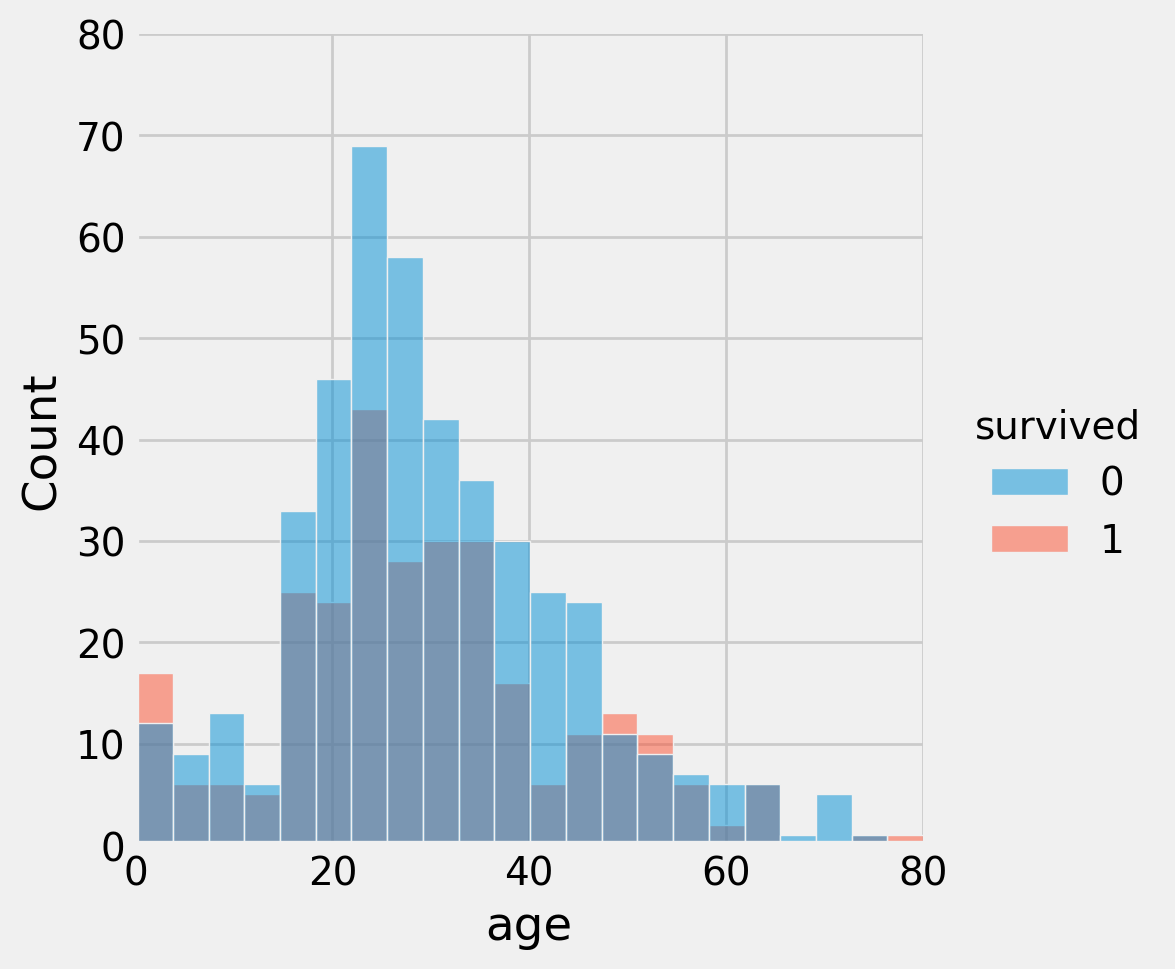

In [32]:
sns.displot(ori_train, x="age", hue="survived")
plt.xlim(0,80)
plt.ylim(0,80)

In [33]:
def alone(family):
  alone=3
  if family ==0:
    alone=1
  elif family <=2:
    alone=2
  else:
    pass
  return alone

train['alone']=train.apply(lambda x : alone(x['family']),axis=1)
test['alone']=test.apply(lambda x : alone(x['family']),axis=1)
ori_te['alone']=ori_te.apply(lambda x : alone(x['family']),axis=1)


In [34]:
# train['age_5']=train.apply(lambda x : x['age']//5, axis =1 )
# test['age_5']=test.apply(lambda x : x['age']//5, axis =1 )
# ori_te['age_5']=ori_te.apply(lambda x : x['age']//5, axis =1 )



In [35]:
def male_2040_alo(gen , age, fam):
    ma =2
    if gen == 'male':
        if (age>20) & (age <40):
            if fam < 2:
                ma =1
    return ma

train['male_2040_alone']= train.apply(lambda x : male_2040_alo(x['gender'], x['age'], x['family']), axis =1)
test['male_2040_alone']= test.apply(lambda x : male_2040_alo(x['gender'], x['age'], x['family']), axis =1)
ori_te['male_2040_alone']= ori_te.apply(lambda x : male_2040_alo(x['gender'], x['age'], x['family']), axis =1)

def female_2030_alo_3(gen, age, fam , pcla):
    fe =2
    if gen == 'female':
        if (age>=20) & (age <= 30):
            if fam <=2:
                if pcla ==3:
                    fe = 1
                    
    return fe

train['fe_2030_alone']= train.apply(lambda x : female_2030_alo_3(x['gender'], x['age'], x['family'],x['pclass']), axis =1)
test['fe_2030_alone']= test.apply(lambda x : female_2030_alo_3(x['gender'], x['age'], x['family'],x['pclass']), axis =1)
ori_te['fe_2030_alone']= ori_te.apply(lambda x : female_2030_alo_3(x['gender'], x['age'], x['family'],x['pclass']), axis =1)

In [36]:
train['male_2040_alone'].value_counts()

male_2040_alone
2    453
1    279
Name: count, dtype: int64

In [37]:
# train.drop(['fare'],axis=1, inplace=True)
# test.drop(['fare'],axis=1, inplace=True)
# ori_te.drop(['fare'],axis=1, inplace=True)

# train.drop(['age'],axis=1, inplace=True)
# test.drop(['age'],axis=1, inplace=True)
# ori_te.drop(['age'],axis=1, inplace=True)

train.drop(['parch'],axis=1, inplace=True)
test.drop(['parch'],axis=1, inplace=True)
ori_te.drop(['parch'],axis=1, inplace=True)

train.drop(['sibsp'],axis=1, inplace=True)
test.drop(['sibsp'],axis=1, inplace=True)
ori_te.drop(['sibsp'],axis=1, inplace=True)

train.drop(['embarked'],axis=1, inplace=True)
test.drop(['embarked'],axis=1, inplace=True)
ori_te.drop(['embarked'],axis=1, inplace=True)

data encoding

In [38]:
#onehotencoding은 문자열을 0과 1로 바꾸는 것이다.
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

In [39]:
train.columns

Index(['pclass', 'gender', 'age', 'fare', 'pclass_gender', 'family',
       'gender_infant', 'alone', 'male_2040_alone', 'fe_2030_alone'],
      dtype='object')

In [40]:
#숫자형과 문자형을 분리한듯, 인코딩할 컬럼과 일반 컬럼을 나눔
normal_cols = [ 'family','age','fare']
enc_cols = list(set(train.columns) - set(normal_cols))
enc_cols

['alone',
 'gender',
 'male_2040_alone',
 'pclass',
 'pclass_gender',
 'gender_infant',
 'fe_2030_alone']

In [41]:
no_category_cols = normal_cols
category_cols = list(set(train.columns) - set(no_category_cols))

train_no_category = train[no_category_cols]
train_category = train[category_cols]

test_no_category = test[no_category_cols]
test_category = test[category_cols]

ori_te_no_category = ori_te[no_category_cols]
ori_te_category = ori_te[category_cols]

In [42]:
category_cols

['alone',
 'gender',
 'male_2040_alone',
 'pclass',
 'pclass_gender',
 'gender_infant',
 'fe_2030_alone']

In [43]:
train_category['gender'] = train_category['gender'].map({'male':1, 'female':2}).astype('category')
#train_category['embarked'] = train_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
#train_category['designation'] = train_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
train_category['pclass_gender'] = train_category['pclass_gender'].astype('category')
train_category['gender_infant'] = train_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
#train_category['age_sec'] = train_category['age_sec'].astype('category')
train_category['pclass'] = train_category['pclass'].astype('category')
#rain_category['fare_range'] = train_category['fare_range'].astype('category')
train_category['alone'] = train_category['alone'].astype('category')
train_category['male_2040_alone'] = train_category['male_2040_alone'].astype('category')
train_category['fe_2030_alone'] = train_category['fe_2030_alone'].astype('category')

ori_te_category['gender'] = ori_te_category['gender'].map({'male':1, 'female':2}).astype('category')
#ori_te_category['embarked'] = ori_te_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
#ori_te_category['designation'] = ori_te_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
ori_te_category['pclass_gender'] = ori_te_category['pclass_gender'].astype('category')
ori_te_category['gender_infant'] = ori_te_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
#ori_te_category['age_sec'] = ori_te_category['age_sec'].astype('category')
ori_te_category['pclass'] = ori_te_category['pclass'].astype('category')
#ori_te_category['fare_range'] = ori_te_category['fare_range'].astype('category')
ori_te_category['alone'] = ori_te_category['alone'].astype('category')
ori_te_category['male_2040_alone'] = ori_te_category['male_2040_alone'].astype('category')
ori_te_category['fe_2030_alone'] = ori_te_category['fe_2030_alone'].astype('category')

test_category['gender'] = test_category['gender'].map({'male':1, 'female':2}).astype('category')
#test_category['embarked'] = test_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
#test_category['designation'] = test_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
test_category['pclass_gender'] = test_category['pclass_gender'].astype('category')
test_category['gender_infant'] = test_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
#test_category['age_sec'] = test_category['age_sec'].astype('category')
test_category['pclass'] = test_category['pclass'].astype('category')
#test_category['fare_range'] = test_category['fare_range'].astype('category')
test_category['alone'] = test_category['alone'].astype('category')
test_category['male_2040_alone'] = test_category['male_2040_alone'].astype('category')
test_category['fe_2030_alone'] = test_category['fe_2030_alone'].astype('category')



In [44]:
import category_encoders as ce

_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()
_ori_te_encoded = pd.DataFrame()

for col in category_cols:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(ori_te_category[col])
  _ori_te_encoded = pd.concat([_ori_te_encoded, _encoded], axis=1)

In [45]:
enc_tr = pd.concat([train_no_category, _train_encoded], axis=1)
enc_tr.shape

enc_te = pd.concat([test_no_category, _test_encoded], axis=1)
enc_te.shape

enc_ori_te = pd.concat([ori_te_no_category, _ori_te_encoded], axis=1)
enc_ori_te.shape


(393, 23)

## Scaling

In [46]:
enc_te.isnull().sum().sum()

0

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


In [48]:
scaling_cols = no_category_cols
not_scaling_cols = list(set(enc_tr.columns) - set(scaling_cols))

rbs = MinMaxScaler()
_scaled_tr = rbs.fit_transform(enc_tr[scaling_cols])
_scaled_te = rbs.transform(enc_te[scaling_cols])
_scaled_ori_te = rbs.transform(enc_ori_te[scaling_cols])

print(f'before: {enc_tr.shape} / {enc_te.shape}')
# train
tmp_tr = pd.DataFrame(
    _scaled_tr, 
    columns = scaling_cols
)
scaled_tr = pd.concat(
    [enc_tr[not_scaling_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# test
tmp_te = pd.DataFrame(
    _scaled_te, 
    columns = scaling_cols
)
scaled_te = pd.concat(
    [enc_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# ori_test
tmp_te = pd.DataFrame(
    _scaled_ori_te, 
    columns = scaling_cols
)
scaled_ori_te = pd.concat(
    [enc_ori_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

print(f'after: {scaled_tr.shape} / {scaled_te.shape}')

before: (732, 23) / (184, 23)
after: (732, 23) / (184, 23)


In [49]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [51]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Training

In [52]:
scaled_tr.isnull().sum().sum(), scaled_te.isnull().sum().sum(), scaled_ori_te.isnull().sum().sum()

(0, 0, 0)

In [53]:
scor = 'recall'
kn=6
n_iter = 50
kf = KFold(n_splits=kn, shuffle=True, random_state=42)

In [54]:
hp1 = {
    'n_estimators': 1500,
    'max_depth': 7,
    'random_state' : SEED
}



In [55]:
# tree_model = RandomForestClassifier(**hp1)
# tree_model.fit(scaled_tr, y_tr)

In [56]:
# from sklearn.model_selection import RandomizedSearchCV
# hp={
#     "max_depth" : np.linspace(3,9,4,dtype = int), # 깊이
#     "n_estimators" : np.linspace(1000,2000,5, dtype = int), # 부스팅 단계수
# }
# model = RandomForestClassifier(random_state=42)

# rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(scaled_tr,y_tr)
# rs.best_score_, rs.score(scaled_te,y_te)

In [57]:
# best_model=rs.best_estimator_
# rs.best_params_

In [58]:
# {'n_estimators': 1250, 'max_depth': 3}

In [59]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=kn, shuffle=True, random_state=SEED)

In [60]:
scor = 'recall'
kn=6
n_iter = 50
auc_lst = []

tree_model = RandomForestClassifier(**hp1)
for train_index, valid_index in skf.split(scaled_tr, y_tr):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
  train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]

  # 학습
  tree_model.fit(train_x, train_y)

  # 예측
  valid_pred = tree_model.predict(valid_x) # 예측값
  valid_pred_proba = tree_model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

best_model = tree_model

51 번째 Stratified Stratified K-Fold 정확도: 0.9077517162471396


52 번째 Stratified Stratified K-Fold 정확도: 0.9070366132723112
53 번째 Stratified Stratified K-Fold 정확도: 0.9087528604118994
54 번째 Stratified Stratified K-Fold 정확도: 0.9187643020594967
55 번째 Stratified Stratified K-Fold 정확도: 0.9144736842105263
56 번째 Stratified Stratified K-Fold 정확도: 0.9199084668192219
--------------------------------------------------
교차 검증 auc: 0.9127812738367659


In [61]:
# n_iter = 0
# auc_lst = []
# kf = KFold(n_splits=kn, shuffle=True, random_state=42)

# tree_model = RandomForestClassifier(**hp1)

# for train_index, valid_index in kf.split(scaled_tr):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
#     train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
#     # 학습
#     tree_model.fit(train_x, train_y)
#     # 예측
#     pred = tree_model.predict_proba(valid_x)[:,1]
#     # 평가
    
#     fpr, tpr, thresholds = roc_curve(valid_y,pred)
#     auc_te = auc(fpr, tpr)
#     auc_lst.append(auc_te)
#     print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {tree_model.score(scaled_te, y_te)}')

# best_model = tree_model

In [62]:
#7, 1500으로 두자 그냥

In [63]:
hp2 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': -1,
    'random_state': SEED,
    'objective': 'binary',
    'metric': 'binary_logloss',
    
}



In [64]:
# from sklearn.model_selection import RandomizedSearchCV
# hp={
#     "max_depth" : np.linspace(3,9,4,dtype = int), # 깊이
#     "n_estimators" : np.linspace(900,1500,5, dtype = int), # 부스팅 단계수
#     "learning_rate" : np.logspace(-2,-1.5,3)
# }
# model = LGBMClassifier(random_state=42,verbose=-1)

# rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(scaled_tr,y_tr)
# rs.best_score_, rs.score(scaled_te,y_te)

In [65]:
# best_model2=rs.best_estimator_
# rs.best_params_

In [66]:
# {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.01}

# lgb = LGBMClassifier(**hp2)
# lgb.fit(scaled_tr, y_tr)


In [67]:
n_iter = 0
auc_lst = []

lgb = LGBMClassifier(**hp2)
for train_index, valid_index in skf.split(scaled_tr, y_tr):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
  train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]

  # 학습
  lgb.fit(train_x, train_y)

  # 예측
  valid_pred = lgb.predict(valid_x) # 예측값
  valid_pred_proba = lgb.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

best_model2 = lgb

1 번째 Stratified Stratified K-Fold 정확도: 0.9088958810068649


2 번째 Stratified Stratified K-Fold 정확도: 0.9038901601830663
3 번째 Stratified Stratified K-Fold 정확도: 0.9183352402745996
4 번째 Stratified Stratified K-Fold 정확도: 0.9040331807780321
5 번째 Stratified Stratified K-Fold 정확도: 0.9018878718535469
6 번째 Stratified Stratified K-Fold 정확도: 0.9190503432494279
--------------------------------------------------
교차 검증 auc: 0.9093487795575896


In [68]:
# n_iter = 0
# auc_lst = []
# kf = KFold(n_splits=kn, shuffle=True, random_state=42)

# lgb = LGBMClassifier(**hp2)
# for train_index, valid_index in kf.split(scaled_tr):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
#     train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
#     # 학습
#     lgb.fit(train_x, train_y)
#     # 예측
#     pred = lgb.predict_proba(valid_x)[:,1]
#     # 평가
    
#     fpr, tpr, thresholds = roc_curve(valid_y,pred)
#     auc_te = auc(fpr, tpr)
#     auc_lst.append(auc_te)
#     print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {lgb.score(scaled_te, y_te)}')

# best_model2 = lgb

In [69]:
hp3 = {
    'n_estimators': 1100,
    'max_depth': 7,
    'learning_rate' : 0.01,
    'verbose': 0,
    'random_state': SEED
    
}


In [70]:
# from sklearn.model_selection import RandomizedSearchCV
# hp={
#     "max_depth" : np.linspace(3,12,5,dtype = int), # 깊이
#     "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
#     "learning_rate" : np.logspace(-3, -1, 3)
# }
# model = CatBoostClassifier(random_state=42,verbose=2)

# rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(scaled_tr,y_tr)
# rs.best_score_, rs.score(scaled_te,y_te)

In [71]:
# best_model3=rs.best_estimator_
# rs.best_params_

In [72]:
# {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01}

In [73]:
# from sklearn.metrics import roc_auc_score
# pred = rs.predict_proba(scaled_te)[:,1]
# roc_auc_score(y_te,pred)

In [74]:
# from sklearn.metrics import classification_report,confusion_matrix
# def print_scores(y_te,pred):
#   print(confusion_matrix(y_te, pred))
#   print('-'*50)
#   print(classification_report(y_te, pred))

In [75]:
# pred = rs.best_estimator_.predict(scaled_te)
# print_scores(y_te, pred)

In [76]:
# best_model3=rs.best_estimator_

In [77]:
# cat_mo = CatBoostClassifier(**hp3)
# cat_mo.fit(scaled_tr, y_tr)

In [78]:
n_iter = 0
auc_lst = []

cat_mo = CatBoostClassifier(**hp3)
for train_index, valid_index in skf.split(scaled_tr, y_tr):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
  train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]

  # 학습
  cat_mo.fit(train_x, train_y)

  # 예측
  valid_pred = cat_mo.predict(valid_x) # 예측값
  valid_pred_proba = cat_mo.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

best_model3 = cat_mo

1 번째 Stratified Stratified K-Fold 정확도: 0.9117562929061785
2 번째 Stratified Stratified K-Fold 정확도: 0.9084668192219679
3 번째 Stratified Stratified K-Fold 정확도: 0.9044622425629291
4 번째 Stratified Stratified K-Fold 정확도: 0.9047482837528605
5 번째 Stratified Stratified K-Fold 정확도: 0.9047482837528604
6 번째 Stratified Stratified K-Fold 정확도: 0.9126144164759726
--------------------------------------------------
교차 검증 auc: 0.9077993897787948


In [79]:
# n_iter = 0
# auc_lst = []
# kf = KFold(n_splits=kn, shuffle=True, random_state=42)

# cat_mo = CatBoostClassifier(**hp3)
# for train_index, valid_index in kf.split(scaled_tr):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
#     train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
#     # 학습
#     cat_mo.fit(train_x, train_y)
#     # 예측
#     pred = cat_mo.predict_proba(valid_x)[:,1]
#     # 평가
    
#     fpr, tpr, thresholds = roc_curve(valid_y,pred)
#     auc_te = auc(fpr, tpr)
#     auc_lst.append(auc_te)
#     print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {cat_mo.score(scaled_te, y_te)}')

# best_model3 = cat_mo

In [80]:
# # 모델 생성
# cat_mo = CatBoostClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200,1500],
#     #'iterations ': [1000,2000],
#     'max_depth': [3,5],
#     'learning_rate' : [0.015,0.01],
#     'random_state':[42],
#     'verbose' : [0],
#     'loss_function':['Logloss','CrossEntropy'],
# }

# # Grid Search + Cross Validation 모두 실행
# grid_search = GridSearchCV(estimator=cat_mo, param_grid=param_grid, cv=3, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params3 = grid_search.best_params_
# best_model3 = grid_search.best_estimator_
# best_score3 = grid_search.best_score_

# print("Best Hyperparameters:", best_params3)
# print("Best Model:", best_model3)
# print("Best Model Score:", best_score3)

# best_model3 = cat_mo


In [81]:
# # 모델 생성 estimor = 1200, 0.01
# light = LGBMClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200,1500],
#     'max_depth': [3],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
#     'verbose': [0]
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=light, param_grid=param_grid, cv=4, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params2 = grid_search.best_params_
# best_model2 = grid_search.best_estimator_
# best_score2= grid_search.best_score_

# print("Best Hyperparameters:", best_params2)
# print("Best Model:", best_model2)
# print("Best Model Score:", best_score2)


In [82]:
hp4 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': 0,
    'random_state': SEED
    
}



In [83]:
n_iter = 0
auc_lst = []

XGB_mo = XGBClassifier(**hp4)
for train_index, valid_index in skf.split(scaled_tr, y_tr):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
  train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]

  # 학습
  XGB_mo.fit(train_x, train_y)

  # 예측
  valid_pred = XGB_mo.predict(valid_x) # 예측값
  valid_pred_proba = XGB_mo.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

best_model4 = XGB_mo

1 번째 Stratified Stratified K-Fold 정확도: 0.9163329519450799


2 번째 Stratified Stratified K-Fold 정확도: 0.9061784897025171
3 번째 Stratified Stratified K-Fold 정확도: 0.9163329519450801
4 번째 Stratified Stratified K-Fold 정확도: 0.9007437070938213
5 번째 Stratified Stratified K-Fold 정확도: 0.9130434782608696
6 번째 Stratified Stratified K-Fold 정확도: 0.9223398169336384
--------------------------------------------------
교차 검증 auc: 0.9124952326468344


In [84]:
# n_iter = 0
# auc_lst = []
# kf = KFold(n_splits=kn, shuffle=True, random_state=42)

# XGB_mo = XGBClassifier(**hp4)
# for train_index, valid_index in kf.split(scaled_tr):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
#     train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
#     # 학습
#     XGB_mo.fit(train_x, train_y)
#     # 예측
#     pred = XGB_mo.predict_proba(valid_x)[:,1]
#     # 평가
    
#     fpr, tpr, thresholds = roc_curve(valid_y,pred)
#     auc_te = auc(fpr, tpr)
#     auc_lst.append(auc_te)
#     print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {XGB_mo.score(scaled_te, y_te)}')

# best_model4 = XGB_mo

In [85]:
# # 모델 생성
# cat_mo = CatBoostClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200],
#     'max_depth': [3,4],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
#     'verbose': [0]
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=cat_mo, param_grid=param_grid, cv=3, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params3 = grid_search.best_params_
# best_model3 = grid_search.best_estimator_
# best_score3 = grid_search.best_score_

# print("Best Hyperparameters:", best_params3)
# print("Best Model:", best_model3)
# print("Best Model Score:", best_score3)


In [86]:
# # 모델 생성
# XGB_mo = XGBClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200, 1800,1500],
#     'max_depth': [3,4,5],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=XGB_mo, param_grid=param_grid, cv=2, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params4 = grid_search.best_params_
# best_model4 = grid_search.best_estimator_
# best_score4 = grid_search.best_score_

# print("Best Hyperparameters:", best_params4)
# print("Best Model:", best_model4)
# print("Best Model Score:", best_score4)


In [87]:
'''
estimer 2000일때 maxdepth는 9일때 제일 굿
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 1400}
Best Model: <catboost.core.CatBoostClassifier object at 0x000002310F4E44D0>
Best Model Score: 0.8804668991518474

'''

"\nestimer 2000일때 maxdepth는 9일때 제일 굿\nBest Hyperparameters: {'max_depth': 5, 'n_estimators': 1400}\nBest Model: <catboost.core.CatBoostClassifier object at 0x000002310F4E44D0>\nBest Model Score: 0.8804668991518474\n\n"

## Evaluation

In [88]:
rfc = tree_model

In [89]:
score_tr = rfc.score(scaled_tr, y_tr)
y_tr_pred= rfc.predict_proba(scaled_tr)[:,1]
score_te = rfc.score(scaled_te, y_te) 

score_tr, score_te  

(0.9016393442622951, 0.8586956521739131)

In [90]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9609077040427155


In [91]:
y_pred0 = rfc.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred0)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8856516290726817


In [92]:
ori_te_pred = rfc.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [93]:
df_feature_importances = pd.DataFrame(rfc.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(23, 2)


,index,0
0,gender_infant_1.0,0.159961
1,gender_1.0,0.143018
2,gender_2.0,0.138452
3,gender_infant_2.0,0.098738
4,fare,0.096385
5,age,0.093635
6,family,0.036747
7,pclass_gender_1.0,0.030375
8,male_2040_alone_2.0,0.026320
9,male_2040_alone_1.0,0.024729


In [94]:
args.results.append(
    {
        'model': 'rfc',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# light

In [95]:
light=best_model2
score_tr = light.score(scaled_tr, y_tr)
y_tr_pred= light.predict_proba(scaled_tr)[:,1]
score_te = light.score(scaled_te, y_te) 

score_tr, score_te  


(0.9030054644808743, 0.842391304347826)

In [96]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9539473684210527


In [97]:
y_pred2 = light.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred2)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.874812030075188


In [98]:

ori_te_pred = light.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape
df_feature_importances = pd.DataFrame(light.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
# plot_importance(cat)
# plt.show()
args.results.append(
    {
        'model': 'light',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

(23, 2)


# Cat

In [99]:
cat=best_model3

In [100]:
score_tr = cat.score(scaled_tr, y_tr)
y_tr_pred= cat.predict_proba(scaled_tr)[:,1]
score_te = cat.score(scaled_te, y_te) 

score_tr, score_te  

(0.930327868852459, 0.8478260869565217)

In [101]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9694134566488685


In [102]:
from sklearn.metrics import roc_curve, auc 

y_pred3 = cat.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred3)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8782581453634085


In [103]:
ori_te_pred = cat.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [104]:
df_feature_importances = pd.DataFrame(cat.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
# plot_importance(cat)
# plt.show()

(23, 2)


In [105]:
args.results.append(
    {
        'model': 'cat',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# XGB

In [106]:
xgb=best_model4

In [107]:
score_tr = xgb.score(scaled_tr, y_tr)
y_tr_pred= xgb.predict_proba(scaled_tr)[:,1]
score_te = xgb.score(scaled_te, y_te) 

score_tr, score_te  

(0.8989071038251366, 0.8532608695652174)

In [108]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9549246758199847


In [109]:
from sklearn.metrics import roc_curve, auc 

y_pred4 = xgb.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred4)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8796365914786968


In [110]:
ori_te_pred = xgb.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [111]:
df_feature_importances = pd.DataFrame(xgb.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')



(23, 2)


In [112]:
args.results.append(
    {
        'model': 'XGB_',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# Submission

In [113]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_tr,auc_te,len_features,feaute_importances,create_dt,ori_te_pred
0,rfc,0.901639,0.858696,0.960908,0.885652,23,"[gender_infant_1.0, gender_1.0, gender_2.0, ge...",0217,"[0.6913871246732701, 0.9693009829091822, 0.935..."
3,XGB_,0.898907,0.853261,0.954925,0.879637,23,"[gender_infant_1.0, gender_1.0, pclass_1.0, pc...",0217,"[0.71134293, 0.9735107, 0.8874076, 0.08846814,..."
2,cat,0.930328,0.847826,0.969413,0.878258,23,"[age, fare, gender_infant_1.0, gender_1.0, gen...",0217,"[0.6745047054740089, 0.9436030129203192, 0.940..."
1,light,0.903005,0.842391,0.953947,0.874812,23,"[fare, age, family, pclass_3.0, gender_1.0, pc...",0217,"[0.6507395482675393, 0.9587037638474448, 0.901..."


In [114]:
# plot_importance(modelV0)  0.34
# plt.show()

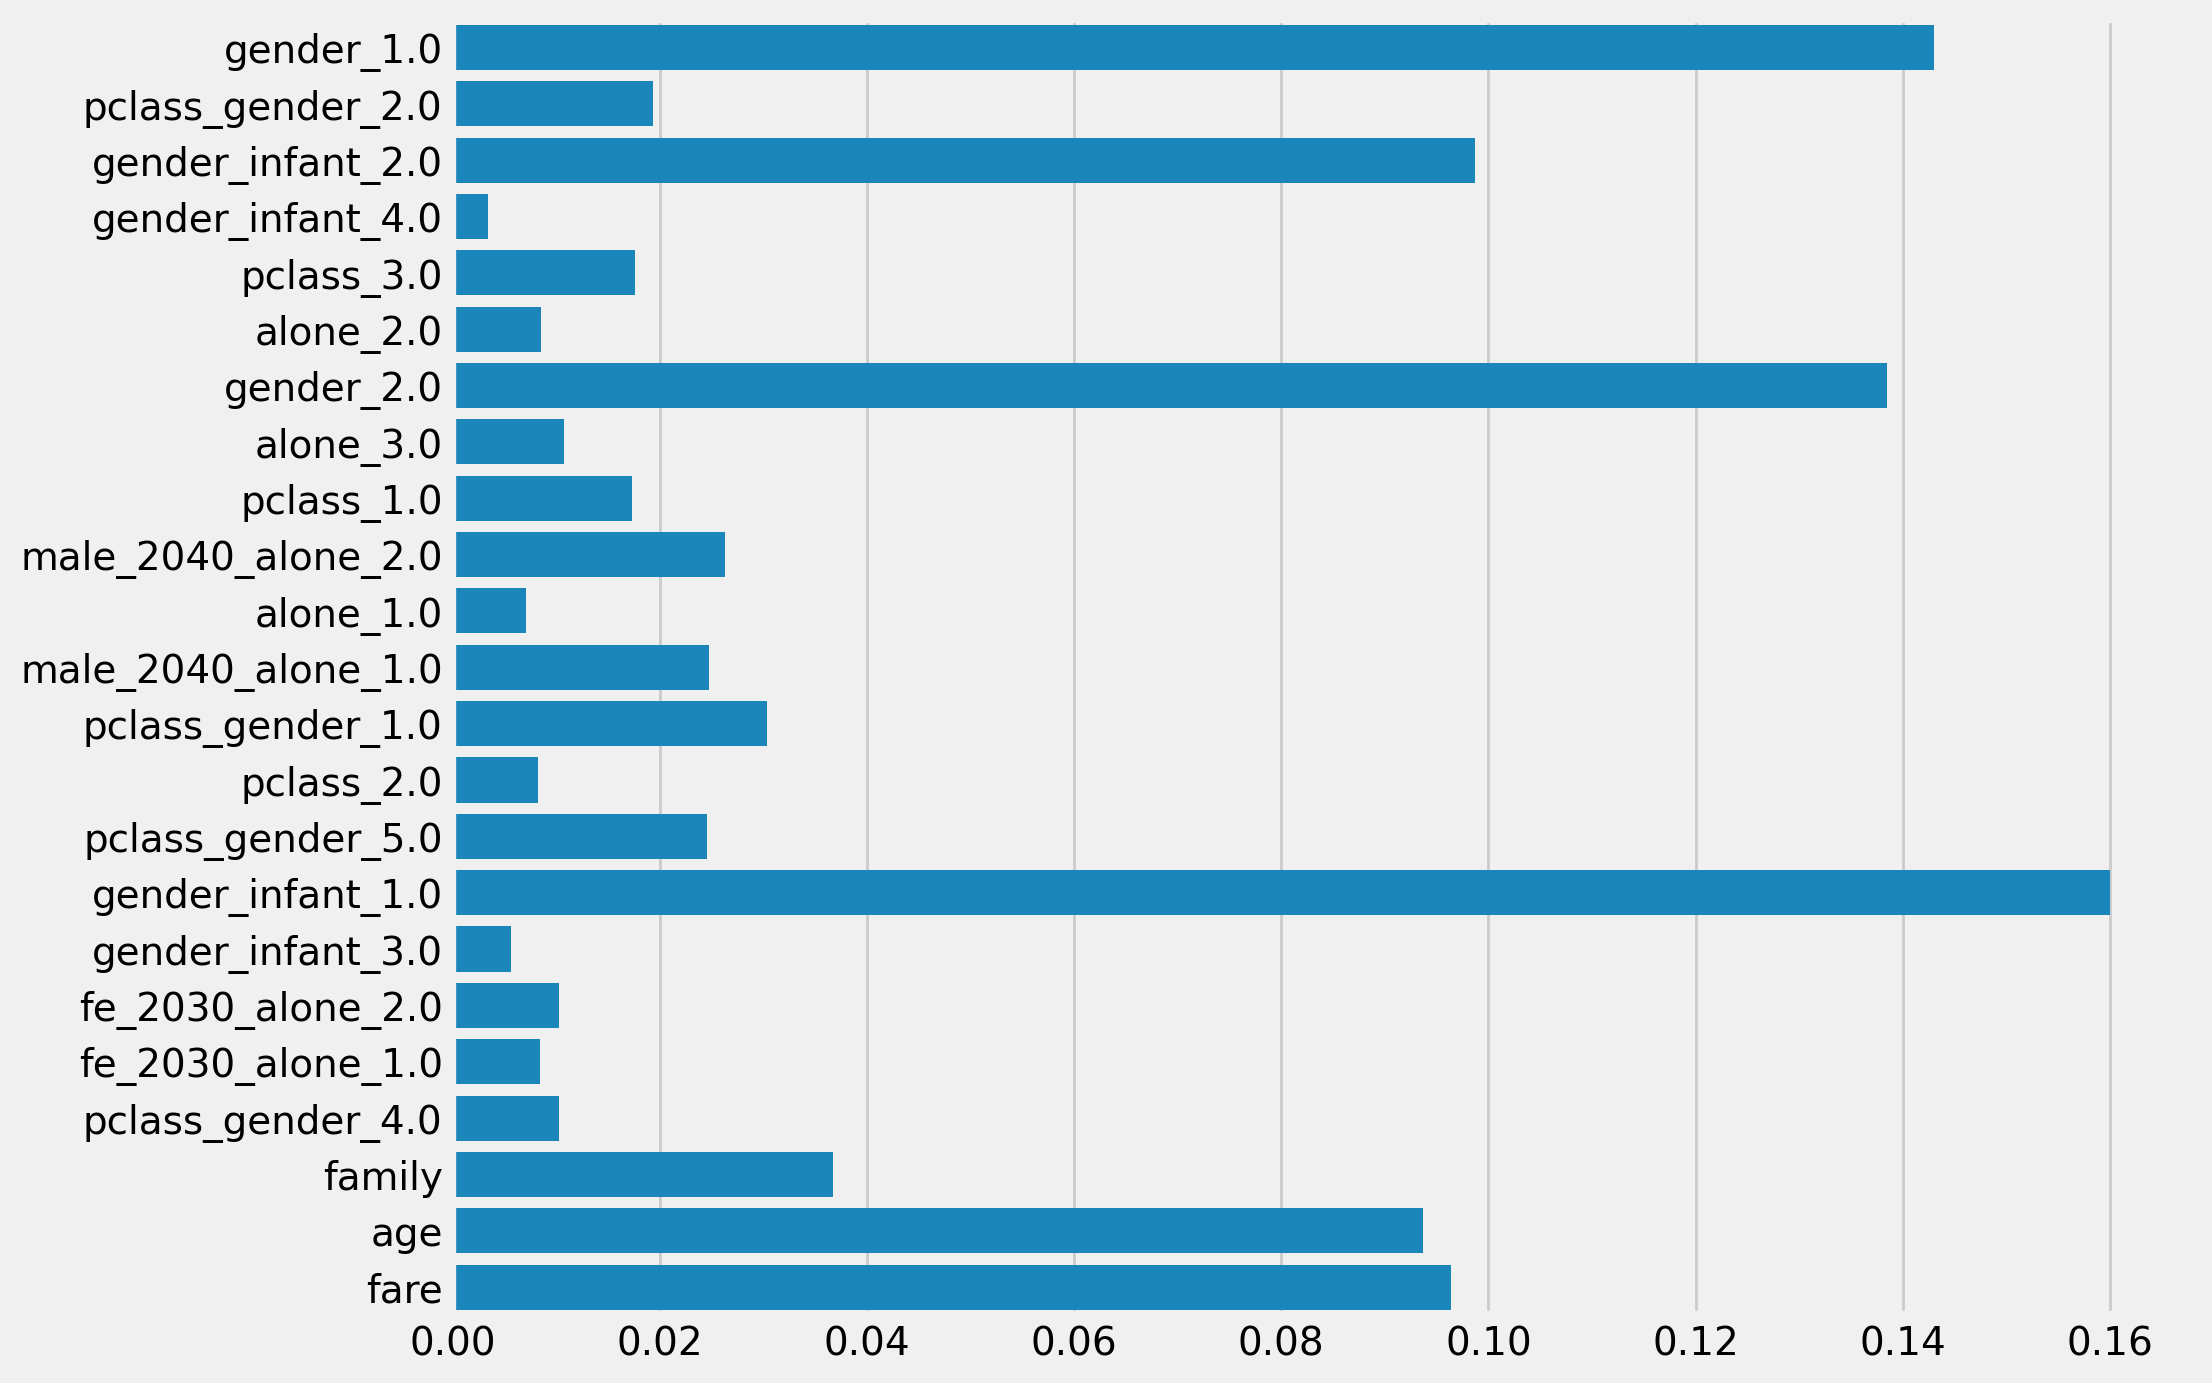

In [115]:
plt.figure(figsize=(10,8))

sns.barplot(x=rfc.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

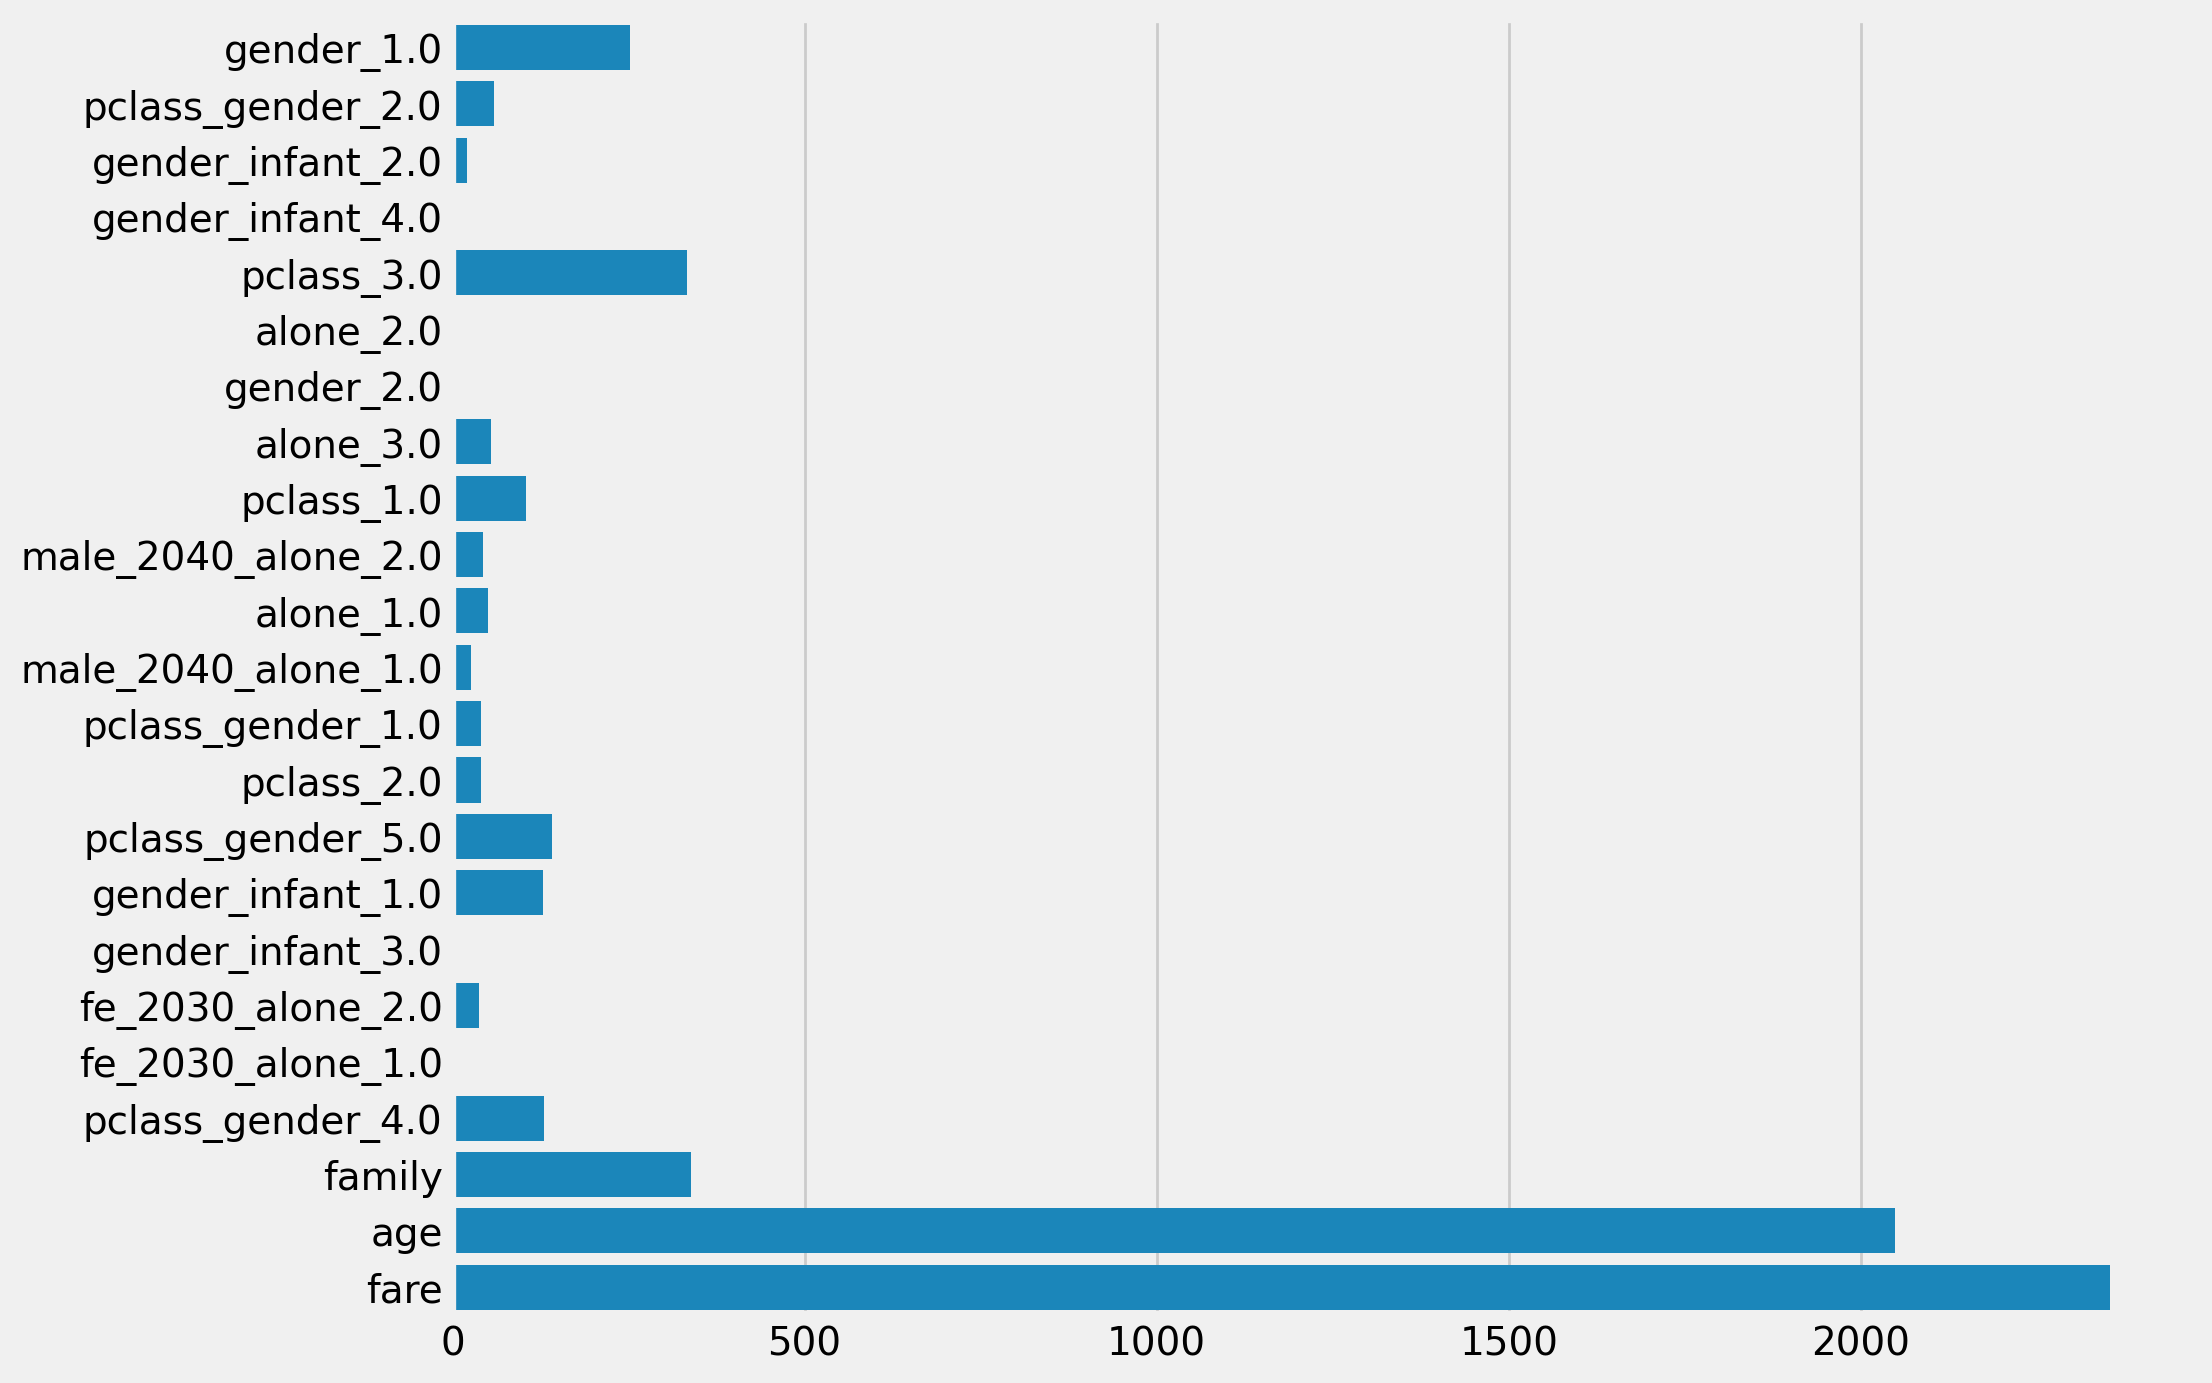

In [116]:
plt.figure(figsize=(10,8))

sns.barplot(x=light.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

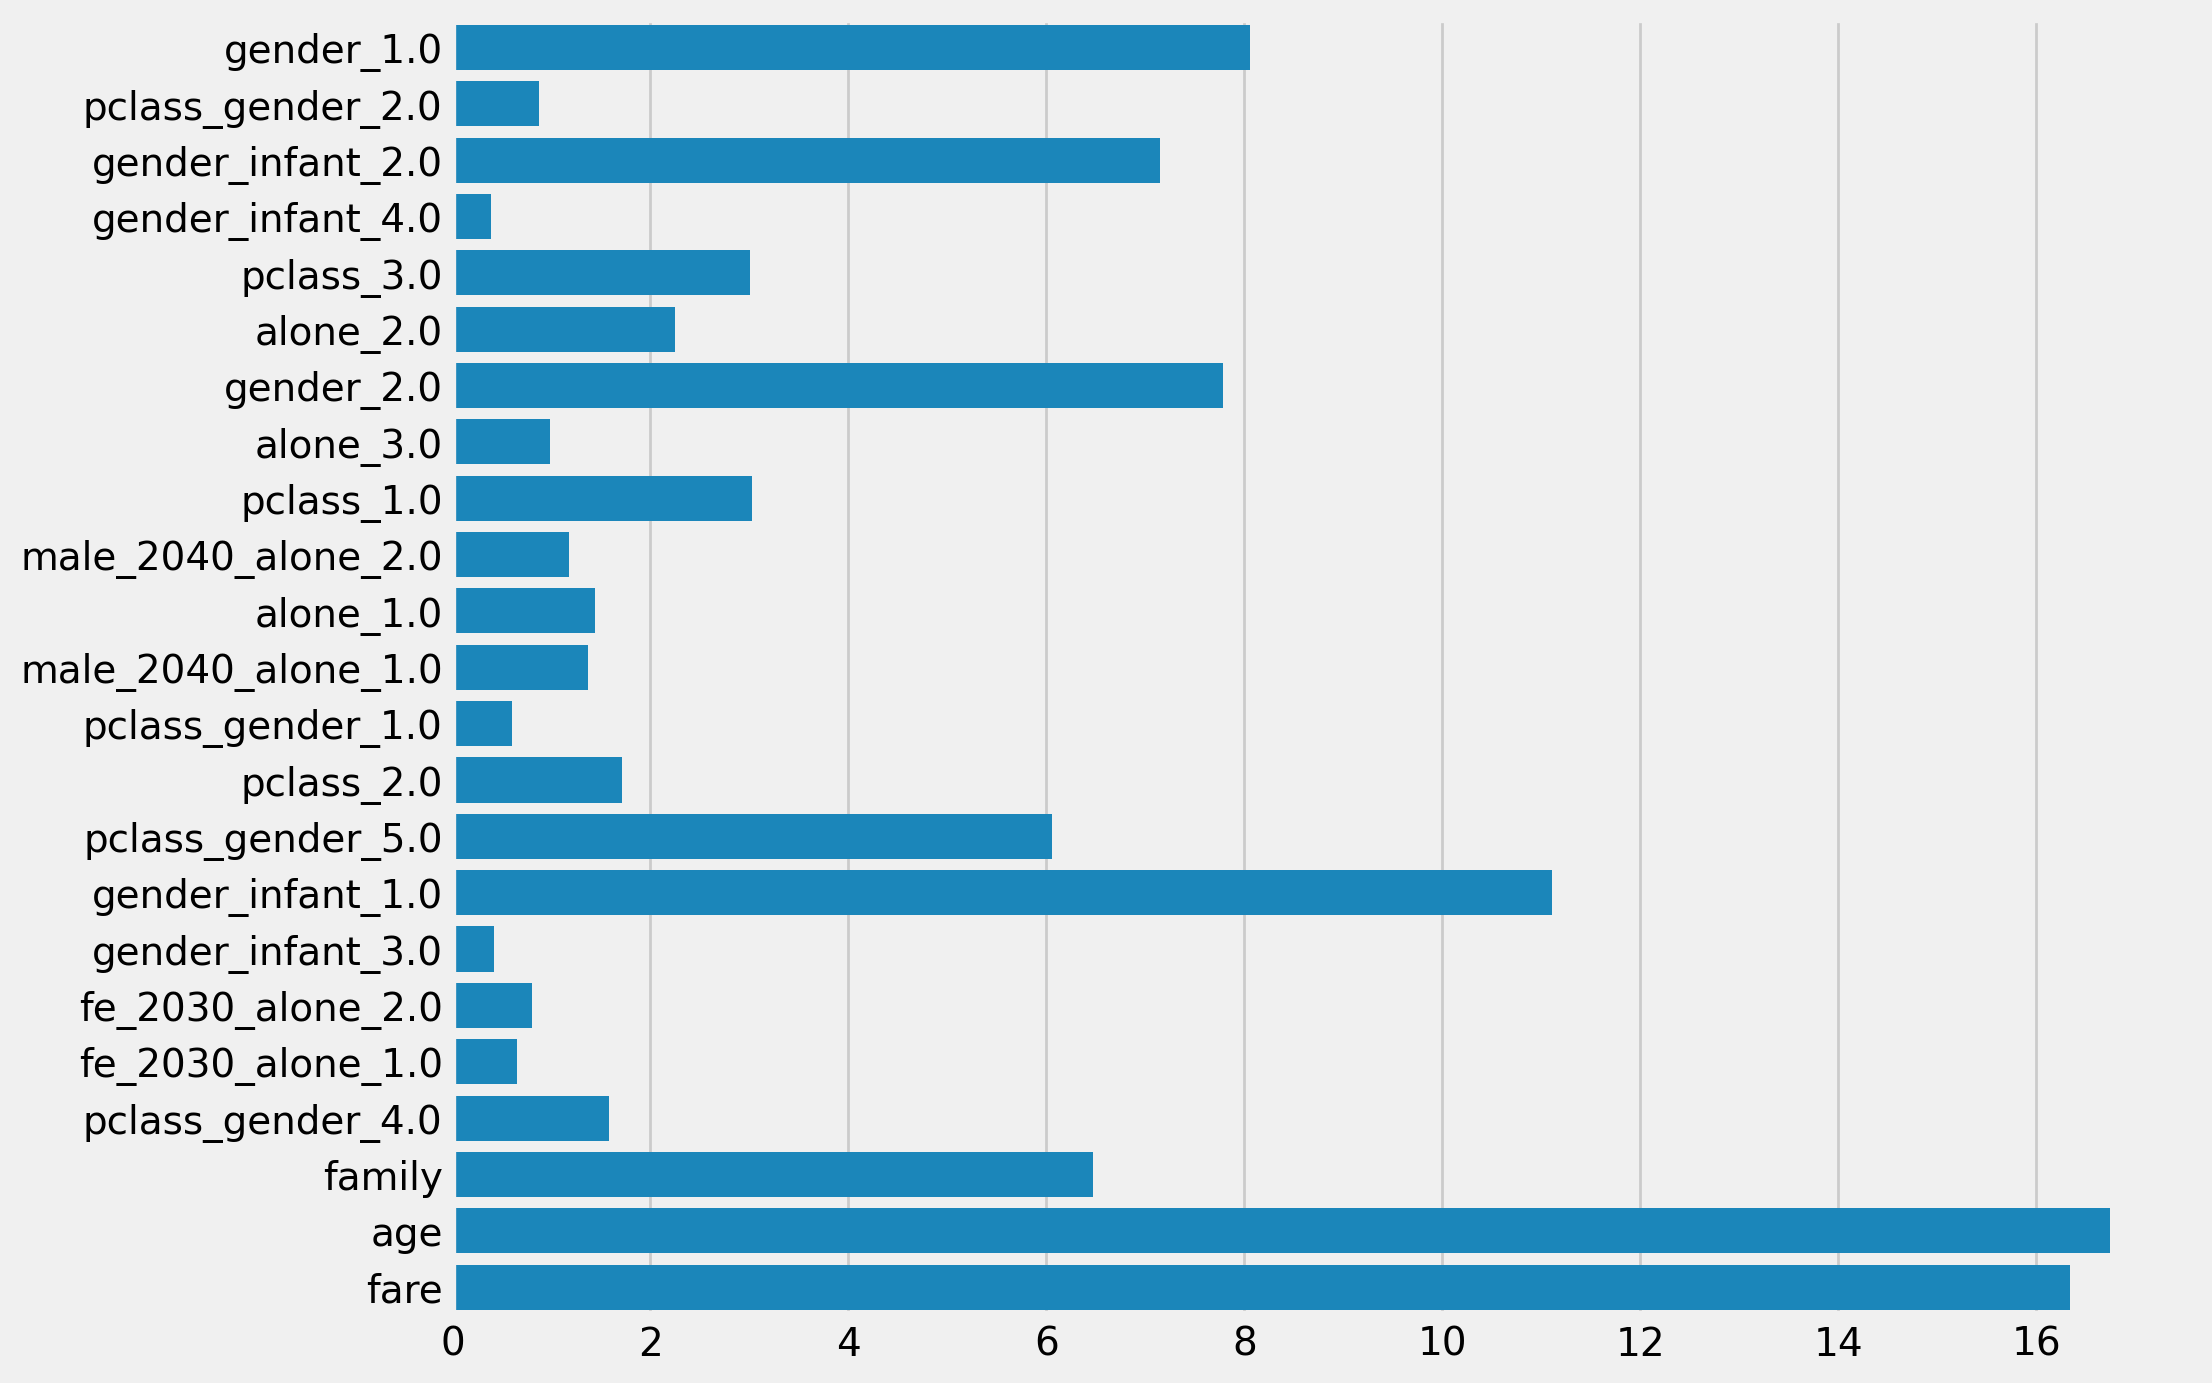

In [117]:
plt.figure(figsize=(10,8))

sns.barplot(x=cat.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

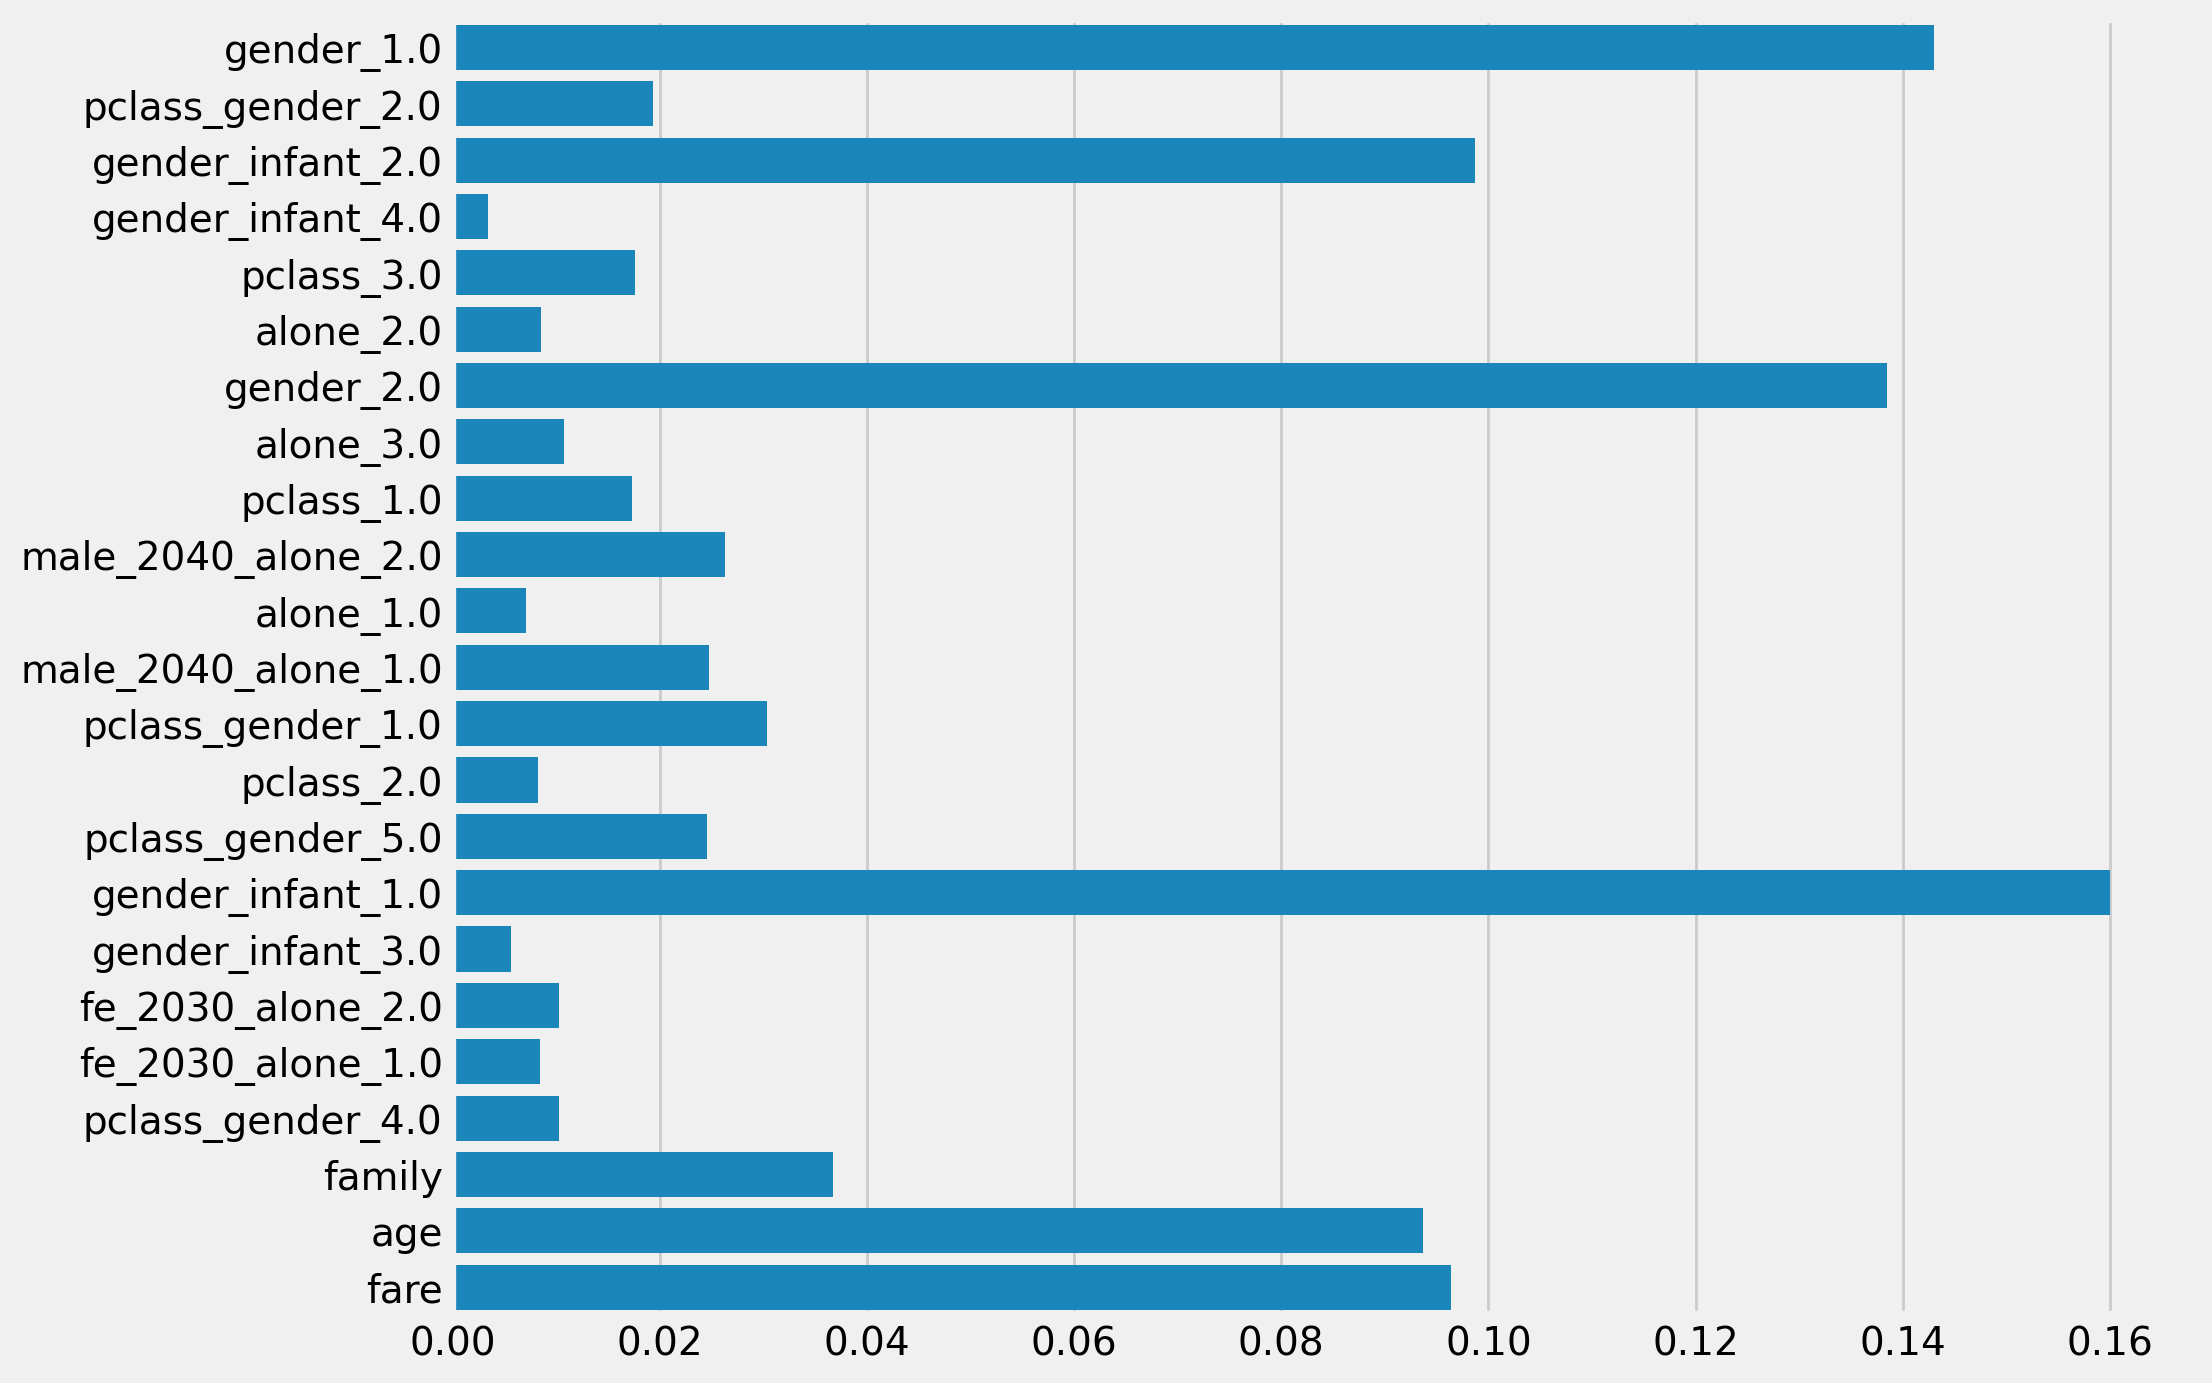

In [118]:
plt.figure(figsize=(10,8))

sns.barplot(x=rfc.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

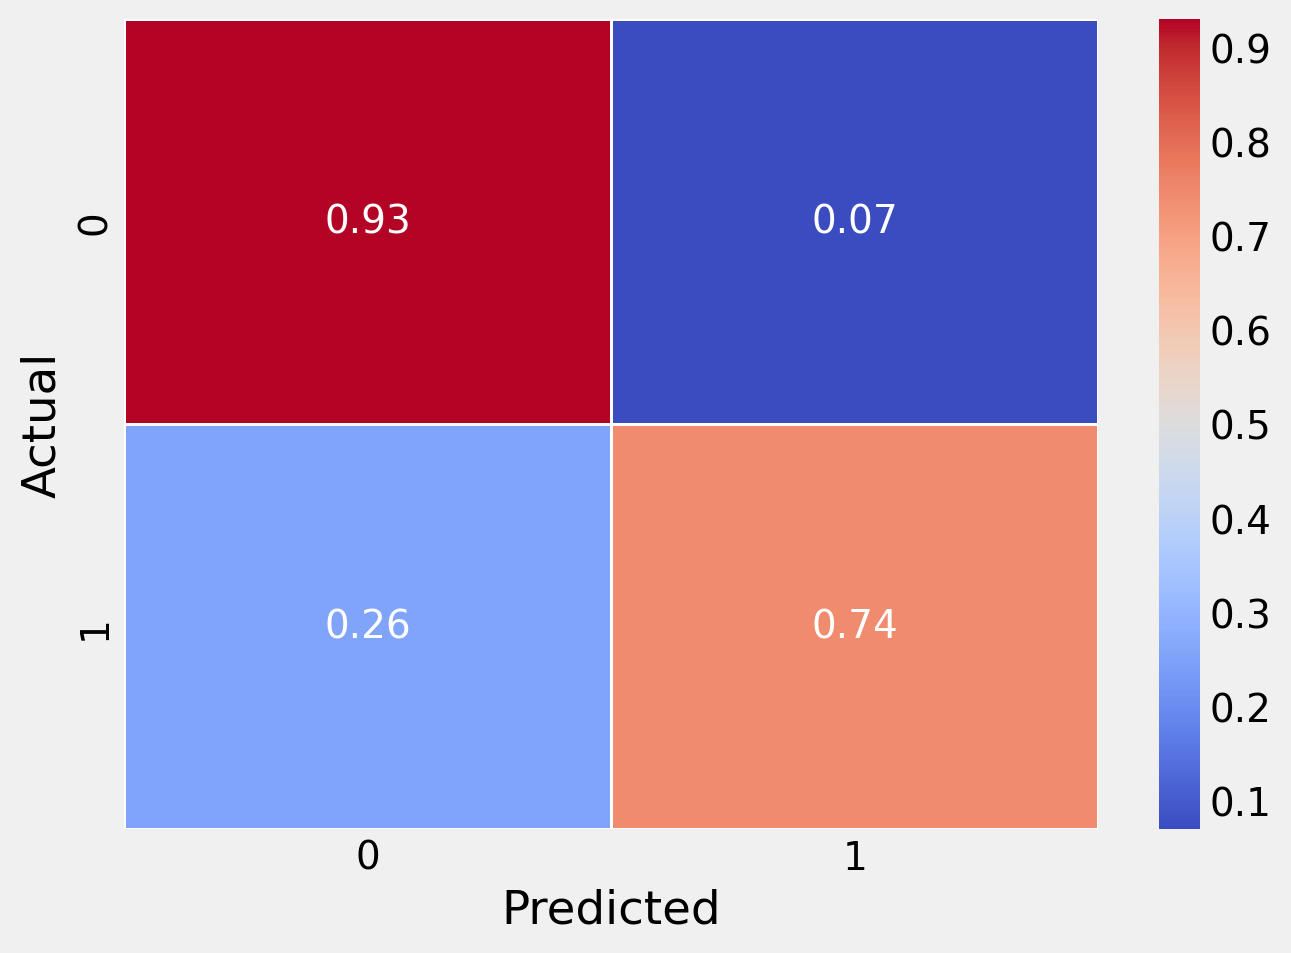

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred0), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


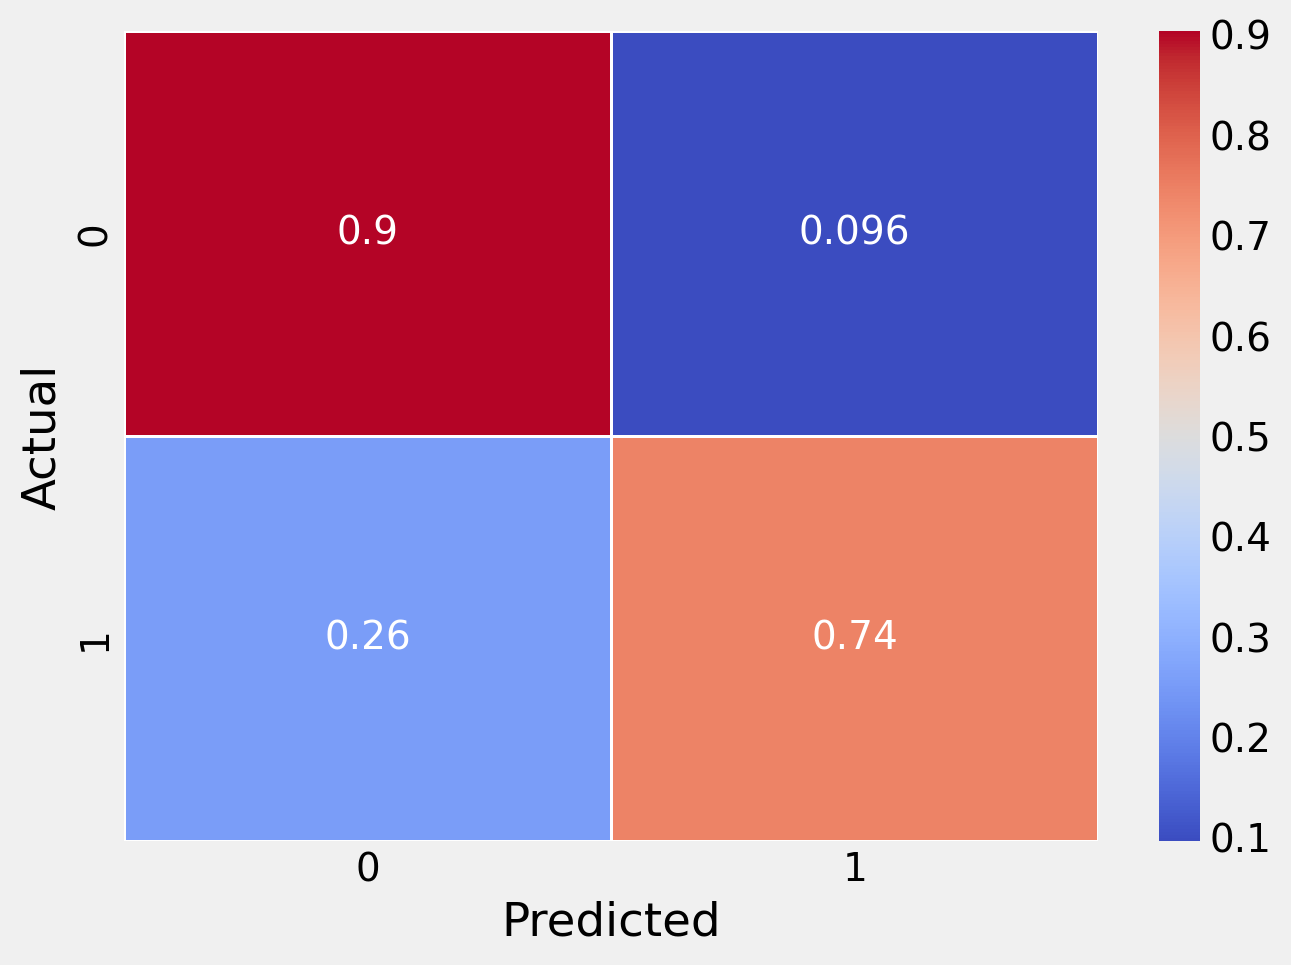

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred2), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


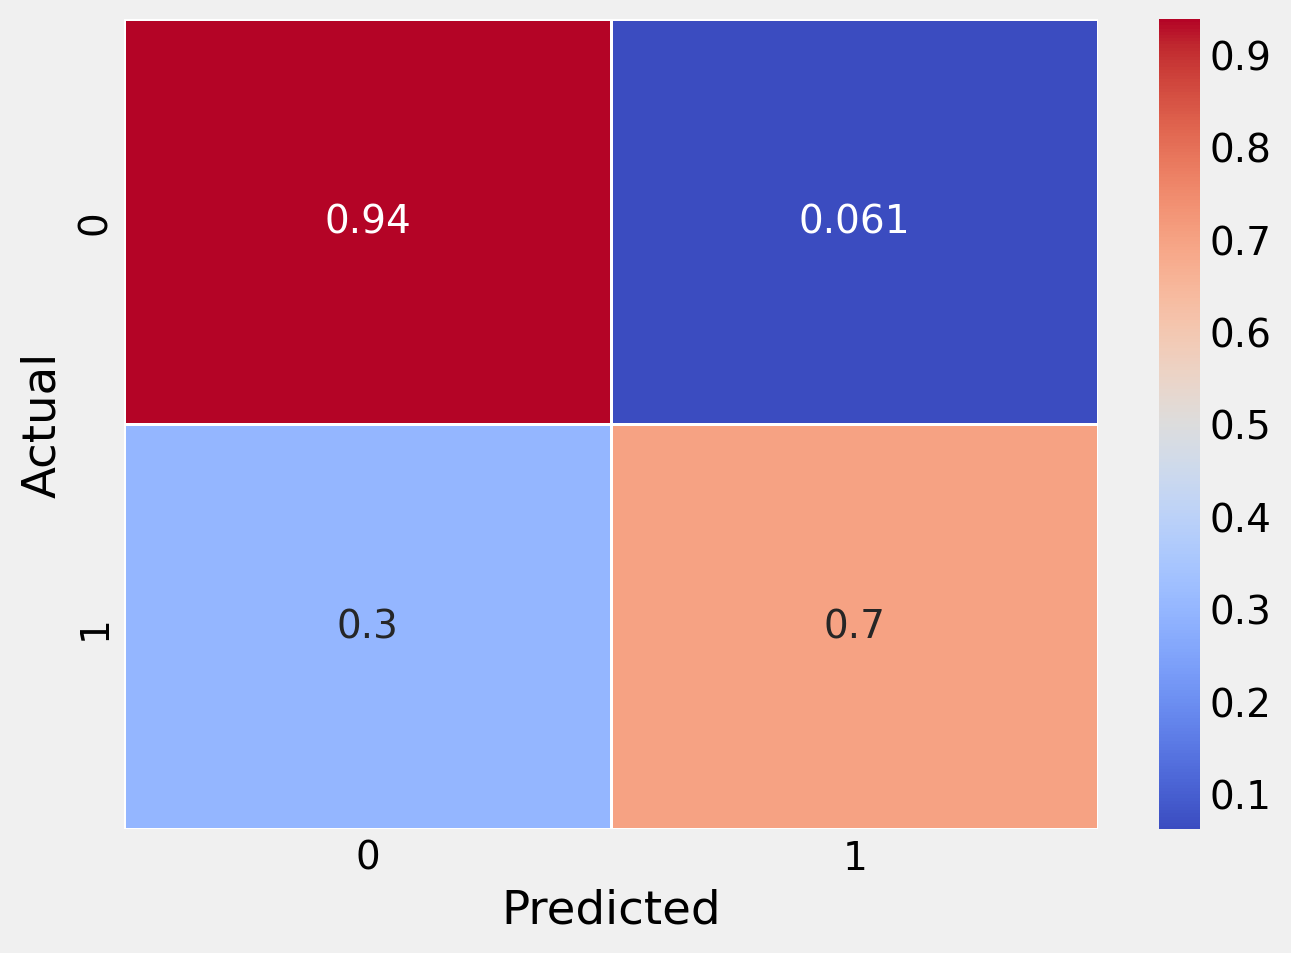

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred3), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


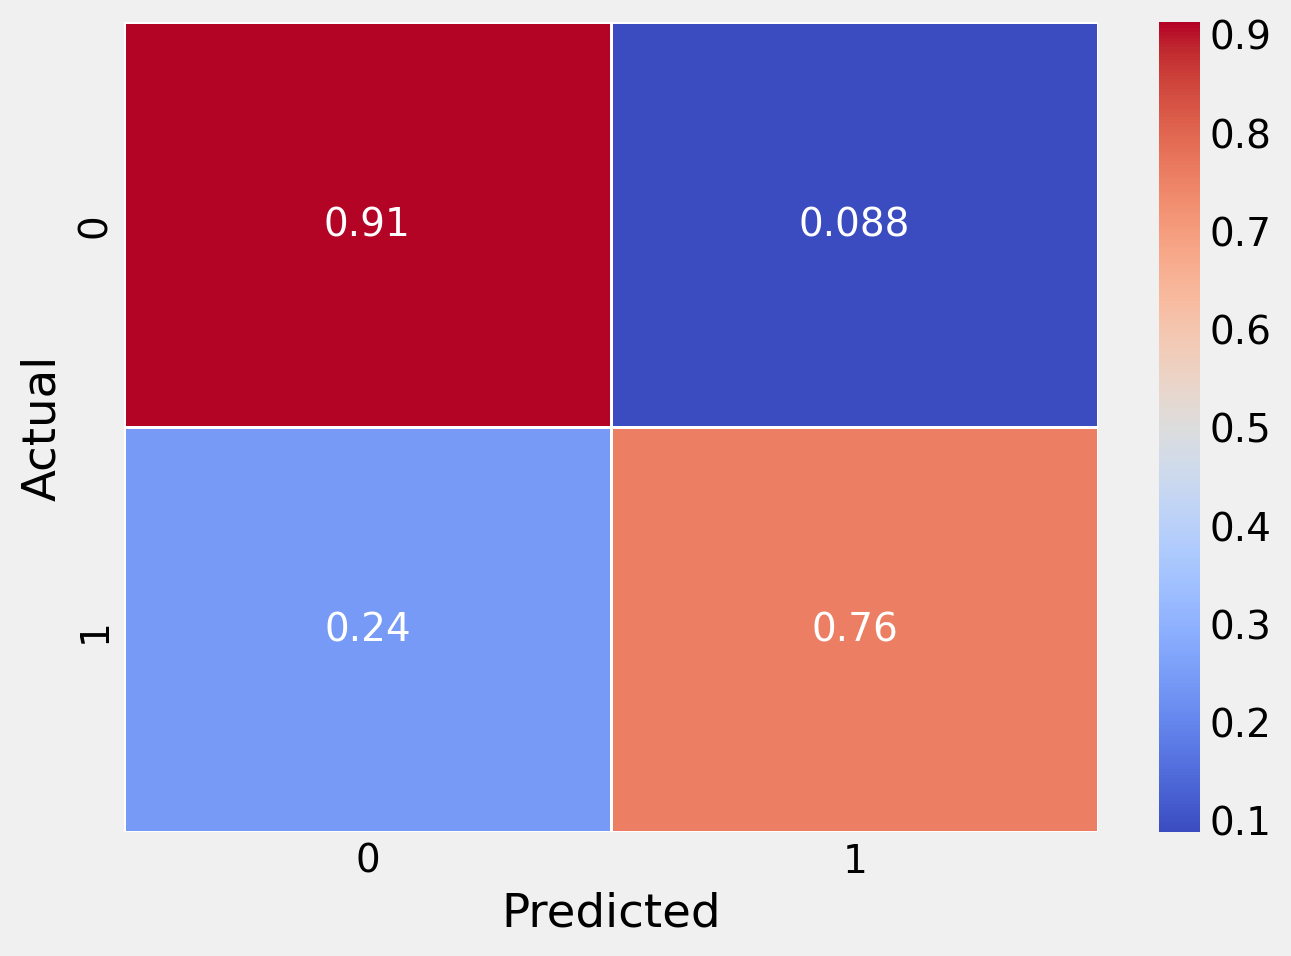

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred4), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 결과 해석

In [123]:
# pandas의 데이터 프레임을 슬라이싱할때 사용한 모듈은 iloc, loc임!!!
# 인덱스(또는 컬럼)의 조건이 True인 것으로 정의를 하면 사용할 있음
tmp_train=pd.concat([X_te.copy().reset_index(drop=True), y_te.copy().reset_index(drop=True)],axis=1)
tmp_train['pred'] = np.round(y_pred2)
tmp_train.shape

(184, 12)

In [124]:
# FP정의
# 모델은 True & 실제값은 False인 데이터
c1 = tmp_train['survived'] == 0 # 실제값은 False
c2 = tmp_train['pred'] == 1 # 모델은 True
c = c1 & c2

tmp_train.loc[c]

,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,survived,pred
13,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C,0,1.0
43,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S,0,1.0
44,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q,0,1.0
49,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,0,1.0
75,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,0,1.0
87,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,0,1.0
119,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S,0,1.0
122,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,0,1.0
133,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S,0,1.0
147,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S,0,1.0


In [125]:
ori_train.groupby(['embarked'])['survived'].mean()

embarked
C    0.486772
Q    0.493827
S    0.330233
Name: survived, dtype: float64

In [126]:
# FN정의
# 모델은 False & 실제값은 True인 데이터
c1 = tmp_train['survived'] == 1 # 실제값은 True
c2 = tmp_train['pred'] == 0 # 모델은 False
c = c1 & c2

k=tmp_train.loc[c]
k

,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,survived,pred
0,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S,1,0.0
8,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S,1,0.0
14,3,"Cacic, Miss. Manda",female,21.0,0,0,315087,8.6625,NaN,S,1,0.0
18,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S,1,0.0
27,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,347089,6.9750,NaN,S,1,0.0
35,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,1,0.0
41,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S,1,0.0
70,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,1,0.0
71,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,0.0
77,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,1,0.0


In [127]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [128]:
df_results.loc[2, ['ori_te_pred']].values[0]

array([0.67450471, 0.94360301, 0.94078939, 0.05108205, 0.96782547,
       0.871088  , 0.07272796, 0.05786632, 0.22402134, 0.2564217 ,
       0.07321036, 0.03704193, 0.70003254, 0.64323718, 0.02334152,
       0.07098519, 0.11331664, 0.0230444 , 0.01028475, 0.05786632,
       0.13653245, 0.02234764, 0.0522503 , 0.00752003, 0.03544918,
       0.12467012, 0.05509257, 0.89381084, 0.48778176, 0.04110839,
       0.8794901 , 0.85535977, 0.0181714 , 0.1037938 , 0.08729061,
       0.03747581, 0.94863772, 0.02053953, 0.12529743, 0.06456597,
       0.06175049, 0.98730552, 0.1300819 , 0.987065  , 0.01582338,
       0.00859673, 0.33915662, 0.02996878, 0.03339882, 0.03169132,
       0.96470593, 0.04015905, 0.99284688, 0.08091959, 0.94936643,
       0.94956742, 0.29707131, 0.08788291, 0.02853074, 0.29444543,
       0.99080652, 0.66363889, 0.63204453, 0.02310207, 0.11879061,
       0.02311084, 0.39713261, 0.87910739, 0.06240484, 0.96592231,
       0.08565249, 0.92934606, 0.54413317, 0.97269884, 0.04623

In [129]:
a

NameError: name 'a' is not defined

In [132]:
submission['survived'] = df_results.loc[2, ['ori_te_pred']].values[0]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.674505
1,917,0.943603
2,918,0.940789
3,919,0.051082
4,920,0.967825
5,921,0.871088
6,922,0.072728
7,923,0.057866
8,924,0.224021
9,925,0.256422


In [133]:
submission.to_csv(args.submission_csv, header=True, index=False)

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# import tensorflow as tf
# print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# Save Results

In [ ]:
args.save_results

'C:/dev/ML_basic/titanic/result/model_results.json'

In [ ]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_tr', 'auc_te', 'len_features',
       'feaute_importances', 'create_dt', 'ori_te_pred'],
      dtype='object')

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
df_results.head()

,model,score_tr,score_te,auc_tr,auc_te,len_features,feaute_importances,create_dt
0,rfc,0.893443,0.875000,0.964825,0.927193,23,"[gender_2.0, gender_infant_1.0, gender_1.0, ge...",0217
3,XGB_,0.890710,0.875000,0.951945,0.916479,23,"[gender_2.0, gender_infant_1.0, pclass_1.0, pc...",0217
2,cat,0.913934,0.875000,0.971745,0.916040,23,"[fare, age, gender_2.0, gender_1.0, gender_inf...",0217
1,light,0.887978,0.869565,0.953073,0.910401,23,"[fare, age, family, gender_2.0, pclass_gender_...",0217


In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'rfc',
  'score_tr': 0.893442623,
  'score_te': 0.875,
  'auc_tr': 0.9648248792,
  'auc_te': 0.9271929825,
  'len_features': 23,
  'feaute_importances': ['gender_2.0',
   'gender_infant_1.0',
   'gender_1.0',
   'gender_infant_2.0',
   'fare',
   'age',
   'family',
   'pclass_gender_1.0',
   'male_2040_alone_2.0',
   'male_2040_alone_1.0'],
  'create_dt': '0217'},
 {'model': 'XGB_',
  'score_tr': 0.8907103825,
  'score_te': 0.875,
  'auc_tr': 0.9519450801,
  'auc_te': 0.9164786967,
  'len_features': 23,
  'feaute_importances': ['gender_2.0',
   'gender_infant_1.0',
   'pclass_1.0',
   'pclass_3.0',
   'pclass_gender_5.0',
   'family',
   'pclass_gender_2.0',
   'pclass_gender_1.0',
   'fare',
   'pclass_gender_4.0'],
  'create_dt': '0217'},
 {'model': 'cat',
  'score_tr': 0.9139344262,
  'score_te': 0.875,
  'auc_tr': 0.9717454869,
  'auc_te': 0.9160401003,
  'len_features': 23,
  'feaute_importances': ['fare',
   'age',
   'gender_2.0',
   'gender_1.0',
   'gender_infant_1

In [ ]:
##